In [22]:
# Author: Abouelaecha Othmane
# Email: ablc.othmane@gmail.com 


# coding: utf-8
import os
import sys
import math
import random as rn

import cv2
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Activation
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Reshape, Conv2DTranspose
from tensorflow.keras.layers import add, concatenate
import matplotlib.pyplot as plt

# Semantic Segmantation using UNET Model

## Semantic Segmentation
It is a pixel level image classification. We try to create a model capable of predicting what each pixel of an image corresponds to in term of classes represented. But unlike the multiclass classification problem or the boundary problem, the output in semantic segmentation are not just labels, it is a high resolution image in which each pixel is classified to a particular class. 
## UNet Structure
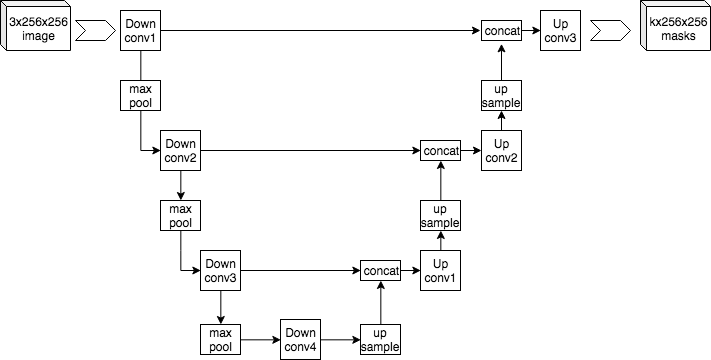
## Problem
The goal of this problem is to get familiar with a simple semantic segmentation problem and to be able to visualize the result of a UNet in action. Going forward we will proceed in the following steps:
1. Create a random image generator with a particular shape drawn in a random color, add noise if possible. The generator needs to output equally a mask of the image. 
2. Create a batch generator that returns tensorflow ready data.
3. Write a function to visualise the results of the generator.
4. Write a UNet model using Keras.
5. Train the model, find suitable hyperparameters and reasonably good preliminary results.
6. Give some predictions and visualize the model at work.

In [42]:
## GLOBAL PARAMETERS
INPUT_CHANNELS = 3
NBR_CLASSES = 1
IMAGE_WEIGHT = 224
IMAGE_WIDTH = 224

loss_name = "binary_crossentropy"

In [43]:
def generate_random_image(_image_height, _image_width, _nbr_channels, _nbr_classes):
    """Creates Backgroud, creates class Object (ellipse), adds white noise

    Args:
        _image_height (int): height
        _image_width (int): width
        _nbr_channels (int): image channels
        _nbr_classes (int): number of objet classes to add

    Returns:
        image_ (np.array):  image representation (_image_height, _image_width, _nbr_channels)
        mask_ (np.array): mask of shape (_image_height, _image_width, _nbr_classes)
    """ 
    image_ = np.zeros((_image_height, _image_width, _nbr_channels), dtype=np.uint8)
    mask_ = np.zeros((_image_height, _image_width, _nbr_classes), dtype=np.uint8)
    colors = np.random.permutation(256)
    image_[:, :, 0] = colors[0]
    image_[:, :, 1] = colors[1]
    image_[:, :, 2] = colors[2]
    obj1_color0 = colors[3]
    obj1_color1 = colors[4]
    obj1_color2 = colors[5]
    while(True):
        center_x = rn.randint(0, _image_width)
        center_y = rn.randint(0, _image_height)
        r_x = rn.randint(10, 50)
        r_y = rn.randint(10, 50)
        if(center_x+r_x < _image_width and center_x-r_x > 0 and center_y+r_y < _image_height and center_y-r_y > 0):
            cv2.ellipse(image_, (int(center_x), int(center_y)), (int(r_x), int(r_y)), int(0), int(0), int(360), (int(obj1_color0), int(obj1_color1), int(obj1_color2)), int(-1))
            cv2.ellipse(mask_, (int(center_x), int(center_y)), (int(r_x), int(r_y)), int(0), int(0), int(360), int(255), int(-1))
            break
    noise_density = rn.uniform(0, 0.1)
    for i in range(_image_height):
        for j in range(_image_width):
            if rn.random() < noise_density:
                image_[i, j, 0] = rn.randint(0, 255)
                image_[i, j, 1] = rn.randint(0, 255)
                image_[i, j, 2] = rn.randint(0, 255)
    return image_, mask_

def batch_generator(batch_size, _image_height, _image_width, _nbr_classes):
    """ A generator of random images

    Args:
        batch_size (int): size of each batch

    Yields:
        images: array of images
        masks: array of corresponding masks
    """    
    while 1:
        images = []
        masks = []
        for i in range(batch_size):
            image_, mask_ = generate_random_image(_image_height, _image_width, 3, _nbr_classes)
            images.append(image_)
            masks.append(mask_)
        images = np.array(images, dtype=np.float32)
        masks = np.array(masks, dtype=np.float32)
        masks /= 255.0 # [0,1]
        masks= masks.reshape(batch_size,_image_height*_image_width,_nbr_classes)
        yield images, masks


def mask2img(_mask, _th=255):
    """Helper function to trasnform a mask to a plottable image

    Args:
        _mask (np.array): shape (h,w,c)
        _th (int, optional): threshold. Defaults to 255.

    Returns:
        img_ (np.array): image
    """    
    img_ = np.zeros((_mask.shape[0], _mask.shape[1], 3), dtype=int)
    for i in range(_mask.shape[0]):
        for j in range(_mask.shape[1]):
            if _mask[i][j][0]>=_th:
                img_[i][j] = [255,255,255]
    return img_

def visualize_generate():
    """Function to visualize an example of generated image
    """    
    image_,mask_ = generate_random_image(IMAGE_HEIGHT, IMAGE_WIDTH, INPUT_CHANNELS, NBR_CLASSES)
    mask_image_ = mask2img(mask_)
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    for ax, interp, img_ in zip(axs, ['Image', 'Mask'], [image_, mask_image_]):
        ax.imshow(img_)
        ax.set_title(interp.capitalize())
    plt.show()

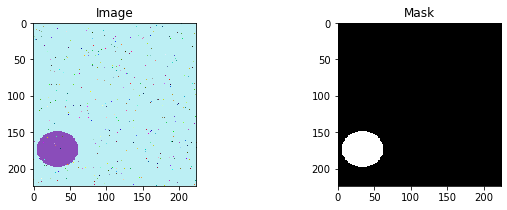

In [44]:
visualize_generate()

## Model

In [45]:
inputs = Input((IMAGE_H, IMAGE_W, INPUT_CHANNELS))

x = BatchNormalization()(inputs)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(NBR_CLASSES, (1, 1), activation='linear')(conv9)

reshape= Reshape((-1,NUMBER_OF_CLASSES))(conv10)
activ = Activation('sigmoid')(reshape)

model = Model(inputs=inputs, outputs=activ)
model.compile(optimizer=Adadelta(learning_rate=0.1), loss='binary_crossentropy')

## Training
We add early stopping callback to avoid overfitting and stop training as soon as validation loss is not getting better.

In [46]:
epochs = 5#*1000
patience = 5
batch_size = 20

callbacks = [
    EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
    ModelCheckpoint('model_weights_'+loss_name+'.h5', monitor='val_loss', save_best_only=True, verbose=0),
]

data_gen_1 = batch_generator(batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, NBR_CLASSES)
data_gen_2 = batch_generator(batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, NBR_CLASSES)

In [47]:
try:
    model.load_weights('model_weights_'+loss_name+'.h5')
except:
    pass
history = model.fit(
    data_gen_1,
    epochs=20,
    steps_per_epoch=10,
    validation_data=data_gen_2,
    validation_steps=2,
    verbose=1,
    shuffle=False,
    callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 2 steps
Epoch 1/20
10/10 [==============================] - 49s 5s/step - loss: 0.5616 - val_loss: 0.2533
Epoch 2/20
10/10 [==============================] - 48s 5s/step - loss: 0.3621 - val_loss: 0.4804
Epoch 3/20
10/10 [==============================] - 48s 5s/step - loss: 0.2461 - val_loss: 0.4981
Epoch 4/20
10/10 [==============================] - 48s 5s/step - loss: 0.2580 - val_loss: 0.3352
Epoch 5/20
10/10 [==============================] - 48s 5s/step - loss: 0.2370 - val_loss: 0.3331
Epoch 6/20
10/10 [==============================] - 48s 5s/step - loss: 0.2368 - val_loss: 0.2960


In [62]:
def visualize_predict():
    """Function to visualize an example of generated image and its prediction
    """    
    image_,mask_ = generate_random_image(IMAGE_HEIGHT, IMAGE_WIDTH, INPUT_CHANNELS, NBR_CLASSES)
    mask_image_ = mask2img(mask_)
    y_pred= model.predict(image_[None,...].astype(np.float32))[0]
    y_pred= y_pred.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NBR_CLASSES))
    y_pred_image_ = mask2img(y_pred,np.percentile(y_pred, 0.99))
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, interp, img_ in zip(axs, ['Image', 'Mask', 'Prediction'], [image_, mask_image_, y_pred_image_]):
        ax.imshow(img_)
        ax.set_title(interp.capitalize())
    plt.show()

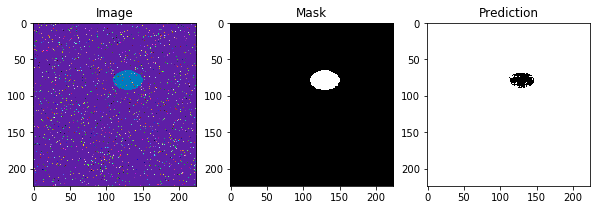

In [64]:
visualize_predict()